In [13]:
import os
from dotenv import load_dotenv
load_dotenv()

from langchain_groq import ChatGroq

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
llm = ChatGroq(model="qwen/qwen3-32b")
result = llm .invoke("Hello")
result

AIMessage(content='<think>\nOkay, the user said "Hello." I should respond in a friendly and welcoming way. Let\'s keep it simple and open-ended to encourage them to ask questions or share what\'s on their mind. Maybe something like, "Hello! How can I assist you today?" That should work.\n</think>\n\nHello! How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 72, 'prompt_tokens': 9, 'total_tokens': 81, 'completion_time': 0.263005687, 'prompt_time': 0.006289156, 'queue_time': 0.194497248, 'total_time': 0.269294843}, 'model_name': 'qwen/qwen3-32b', 'system_fingerprint': 'fp_5cf921caa2', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--ae932ffd-f0e7-4685-8e7c-3d4026abfabb-0', usage_metadata={'input_tokens': 9, 'output_tokens': 72, 'total_tokens': 81})

In [14]:
from typing import Annotated, List
import operator
from typing_extensions import Literal
from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage, SystemMessage
from typing_extensions import TypedDict

In [15]:
class Section(BaseModel):
    name: str=Field(description="Name for this section of the report")
    description: str=Field(description="Brief overview of the main topics and concepts of the section")

class Sections(BaseModel):
    sections: List[Section]=Field(description="Sections of the report")

planner = llm.with_structured_output(Sections)

In [ ]:
### Creating Workers Dynamically in Langgraph
from langgraph.constants import Send

class State(TypedDict):
    topic: str
    sections: list[Section]
    completed_sections: Annotated[list, operator.add] # All wokers write to this key in parallel
    final_report: str

class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list, operator.add]

/var/folders/w0/jqmsjv3s0fdf4vt1c98f61x00000gn/T/ipykernel_54542/202764473.py:2: LangGraphDeprecatedSinceV10: Importing Send from langgraph.constants is deprecated. Please use 'from langgraph.types import Send' instead. Deprecated in LangGraph V1.0 to be removed in V2.0.
  from langgraph.constants import Send


In [17]:
def orchestrator(state: State):
    """Orchestrator that generates a plan for the report"""

    # Generate queries
    report_sections = planner.invoke(
        [
            SystemMessage(content="Generate a plan for the report."),
            HumanMessage(content=f"Here is the report topic: {state["topic"]}")
        ]
    )

    print("Report Sections:", report_sections)

    return {"sections": report_sections.sections}

def llm_call(state: WorkerState):
    """Worker writes a section of the report"""

    section = llm.invoke(
        [
            SystemMessage(content="Write a report section following the provided name and descriptions. Include no preamble for each section. "),
            HumanMessage(content=f"Here is the section name: {state["section"].name} and description: {state["section"].description}"),
        ]
    )

    return {"completed_sections": [section.content]}

def assign_workers(state: State):
    """Assign a worker to each section i the plan"""

    # Kick off section writing in parallel via Send() API
    return [Send("llm_call", {"section": s}) for s in state["sections"]]

def synthesizer(state: State):
    """Synthesize full report from sections"""

    completed_sections = state["completed_sections"]

    completed_report_sections = "\n\n---\n\n".join(completed_sections)

    return {"final_report": completed_report_sections}

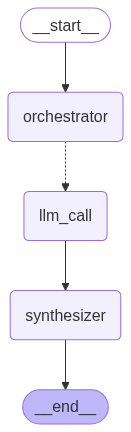

In [18]:
from typing_extensions import Literal, TypedDict
from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

orchestrator_worker_builder = StateGraph(State)
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call", llm_call)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_conditional_edges("orchestrator", assign_workers, ["llm_call"])
orchestrator_worker_builder.add_edge("llm_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

orchestrator_worker = orchestrator_worker_builder.compile()

display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))


In [19]:
state = orchestrator_worker.invoke({"topic": "Create a report on Agentic AI RAGs"})

from IPython.display import Markdown
Markdown(state["final_report"])

TypeError: State() takes no arguments